In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from unidecode import unidecode
from tqdm import tqdm
import json
import re
from IPython.display import HTML
# import itertools
import warnings

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
			font-weight: bolder;
	}
</style>
<h3>Funciones y variables globales</h3>

In [2]:
# archivo conteos y agrupaciones a doc. original
wb_original_results = './Cambios_aplicados/wb_original_results.xlsx'
wb_final_results = './Cambios_aplicados/wb_final_results.xlsx'

# wb libro regs únicos 
wb_regs_unicos = './Cambios_aplicados/wb_regs_unicos.xlsx'

# libro a analizar
# variables files
file_to_analize = './Sitios SEMS.xlsx'

In [3]:
# funciones globales

def save_df_changes(df_object, file_name='Libro_cambios_aplicados'):
  """
  Save workbooks in the default path with xlsx extention
  
	Args:
			df_object (_type_): dataframe to save as file
			file_name (str, optional): filename NO extention
	"""
  try:
    df_object.to_excel(f'./Cambios_aplicados/{file_name}.xlsx', index=None)
    print(f'Se ha exportado el libro: {file_name}.xlsx\nRuta del archivo: "Cambios_aplicados -> {file_name}.xlsx"')
  except PermissionError:
    print("el libro no se pudo exportar, debido a que el libro exportado anteriormente esta abierto, se debe cerrar.")

def get_acronym(state_name):
  """
  get the acronym from the mexican state
  """
  tmp_res = None
  state_name = state_name.upper()
  try:
    stts_mexico = {
      'AGUASCALIENTES' : 'AGS.', 'BAJA CALIFORNIA' : 'B.C.', 'BAJA CALIFORNIA SUR' : 'B.C.S.', 'CAMPECHE' : 'CAMP.', 'COAHUILA DE ZARAGOZA' : 'COAH.', 'COLIMA' : 'COL.', 'CHIAPAS' : 'CHIS.', 'CHIHUAHUA' : 'CHIH.', 'CIUDAD DE MÉXICO' : 'C.D.M.X.', 'DURANGO' : 'DGO.', 'GUANAJUATO' : 'GTO.', 'GUERRERO' : 'GRO.', 'HIDALGO' : 'HGO.', 'JALISCO' : 'JAL.', 'MÉXICO' : 'MÉX.', 'MICHOACÁN DE OCAMPO' : 'MICH.', 'MORELOS' : 'MOR.', 'NAYARIT' : 'NAY.', 'NUEVO LEÓN' : 'N.L.', 'OAXACA' : 'OAX.', 'PUEBLA' : 'PUE.', 'QUERÉTARO' : 'QRO.', 'QUINTANA ROO' : 'Q. ROO.', 'SAN LUIS POTOSÍ' : 'S.L.P.', 'SINALOA' : 'SIN.', 'SONORA' : 'SON.', 'TABASCO' : 'TAB.', 'TAMAULIPAS' : 'TAMPS.', 'TLAXCALA' : 'TLAX.', 'VERACRUZ DE IGNACIO DE LA LLAVE' : 'VER.', 'YUCATÁN' : 'YUC.', 'ZACATECAS' : 'ZAC.'}
    tmp_res = stts_mexico[state_name]
    return tmp_res
  except KeyError:
    return 'SIN INFO.'

def sin_ascentos(nombre: str)-> str:
  """
  reemplazar tildes en palabras
  """
  abc = [
    ('Á', 'A'), ('É', 'E'), ('Í', 'I'), ('Ó', 'O'), ('Ú', 'U'), ('Ü', 'U'), 
    ('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ü', 'u')
    ]
  for a in abc:
    nombre = nombre.replace(a[0], a[1])
  return nombre

def save_df_in_sheet_from_workbook(dataframe, sheetname, workbookname):
  """
  Save a DataFrame into an Excel worksheet inside a specified Excel file.
  
  Arguments:
  - dataframe: The DataFrame to be saved into the Excel worksheet
  - sheetname: The name of the Excel worksheet in which the DataFrame will be written
  - workbookname: The name of the Excel file in which the DataFrame will be saved
  """
  try:
    with pd.ExcelWriter(workbookname, mode='a') as writer:
      dataframe.to_excel(writer, sheet_name=sheetname, index=None)
  except FileNotFoundError:
    with pd.ExcelWriter(workbookname) as writer:
      dataframe.to_excel(writer, sheet_name=sheetname, index=None)
  except ValueError:
    pass

# Función para validar latitudes
def validar_latitud(latitud):
  latitud_patron = r'^[-+]?([1-8]?\d(\.\d+)?|90(\.0+)?)$'
  return re.match(latitud_patron, str(latitud)) is not None

# Patrón de regex para validar longitudes decimales

# Función para validar longitudes
def validar_longitud(longitud):
  # longitud_patron = r'^[-+]?(180(\.0+)?|((1[0-7]\d)|([1-9]?\d))(\.\d+)?)$'
  longitud_patron = r'^-\d+\.\d{2,}$'
  return re.match(longitud_patron, str(longitud)) is not None

lst_reemplazos = [
  ('delegación ', ''), ('delegacion ', ''), ('ciudad ', ''), ('alcaldia ', ''), ('alcaldía ', ''), ('ciudad de ', ''), ('cd. ', ''), ('sta. ', 'santa '), ('gral. ', 'general'), ('dr. ', 'doctor'), ('ciudad del ', ''), ('ciudad de ', ''), ('san ', ''),( '(', ''),( ')', ''), ('francisco', ''), ('juárez', ''), ('juarez', ''), ('ejido ', ''), ('jardines', '')
  ]

In [4]:
# cargar en memoria el archivo de excel
data = pd.read_excel(io=file_to_analize, sheet_name=0, dtype={'Código postal*': object})

# crear dataframe
df = pd.DataFrame(data)

# eliminar data despues de convertirla en un dataframe
del data

In [5]:
# lr_df -> última fila de dataframe
lr = df.shape[0]
display(HTML(f'<h2 style="color: #fb8500;">El archivo tiene tiene {"{:,}".format(lr)} registros y {df.shape[1]} columnas</h2>'))

del lr

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
			font-weight: bolder;
	}
</style>
<h3>Columnas Clave Dependencia (1) y Dependencia (2) </h3>

In [6]:
# importación del catálogo de ramos
tRamos = pd.read_csv('./Compact_inegi_dbLocs/ramo.csv')
lst_ramos = tRamos["cve_ramo"].to_list()
lst_desc_ramos = tRamos['descripcion'].to_list()
dictRamosByID = dict(zip(lst_ramos, lst_desc_ramos))
dictRamosByDesc = dict(zip(lst_desc_ramos, lst_ramos))

In [7]:
# actualizar la columna de clave dependencia y dependencia 

def update_row(row):
    
    clv = row['Clave de la Dependencia*']
    dep = row['Dependencia*']
    
    # si el registro esta en la lista de claves pero el valor de diccionario no corresponde a la dependencia
    if clv in lst_ramos and dictRamosByID[clv] != dep:
        row['Dependencia*'] = dictRamosByID[clv]
    
    # si la clave no esta en la lista de ramos y la clave no es un valor vacio
    elif clv not in lst_ramos and clv not in [' ', '']:
        try:
            row['Dependencia*'] = dictRamosByID[clv]
            row['Clave de la Dependencia*'] = dictRamosByDesc[dep]
        except KeyError:
            row['Clave de la Dependencia*'] = ' '
    return row

df = df.apply(update_row, axis=1)


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
			font-weight: bolder;
	}
</style>
<h3>Columna Clave de inmueble (3) </h3>

In [8]:
# hacer el conteO de la clave inmueble, en primera instancia la clave de inmueble es una código único no vacio

# agrupacion de las claves y conteo de las repeticiones por cada clave
conteo_por_clvs = df.groupby(by='Clave del inmueble*').agg(regs_por_clave=('Clave del inmueble*', 'count')).reset_index()

# mantener solo las claves cuya repetición es mayor a una
conteo_por_clvs_duplicadas_clv =  conteo_por_clvs[conteo_por_clvs['regs_por_clave'] > 1].reset_index()

# segmentacion de conteo donde las claves repetidas estan vacias, solo saber el número de registros vacios
regs_sin_clv = conteo_por_clvs_duplicadas_clv[conteo_por_clvs_duplicadas_clv['Clave del inmueble*'] == " "]['regs_por_clave'][0]

# de las claves que no estan vacias mostrar las claves cuyo conteo es mayor a 1 y su valor es diferente a vacio [" " o ""]
regs_clv_dupl = conteo_por_clvs_duplicadas_clv[conteo_por_clvs_duplicadas_clv['Clave del inmueble*'] != " "]['regs_por_clave'].sum()

print(f'Registros SIN clave asignada: {regs_sin_clv}\nRegistros clave DUPLICADA: {regs_clv_dupl}\nTotal registros: {regs_sin_clv + regs_clv_dupl}')

Registros SIN clave asignada: 26
Registros clave DUPLICADA: 34
Total registros: 60


In [9]:
# agrupación de clave de inmueble y número de registros por clave
conteo_por_clvs_duplicadas_clv = conteo_por_clvs_duplicadas_clv[['Clave del inmueble*','regs_por_clave']]

# creación de una lista de todos los registros duplicados por clave y reemplazo de los vacios por un None
lst_dupli_clv = [x if x != " " and x != "" else None for x in conteo_por_clvs_duplicadas_clv['Clave del inmueble*'].to_list()]

lst_dupli_clv  = [elemento for elemento in lst_dupli_clv if elemento is not None]

# segmentación del dataframe, filtrar solo los registros que estan repetidos en su clave de inmueble en la lista de claves duplicadas
df_regs_duplicados_by_clv = df[df['Clave del inmueble*'].isin(lst_dupli_clv)].sort_values(by='Clave del inmueble*')

# eliminar variables
del tRamos, conteo_por_clvs_duplicadas_clv, lst_desc_ramos, conteo_por_clvs, df_regs_duplicados_by_clv

,Clave del inmueble*,regs_por_clave
0,,26
1,01DBT0028N,2
2,03DPT0001H,2
3,04INM0650E,2
4,06DPT0181F,2
5,07INM09313,2
6,09DBT0155B,2
7,09DBT0156A,2
8,09DBT0171T,2
9,11DBT0001N,2


In [11]:
# validación y creación de estatus de duplicidad en doc. interno
df['status_intern_duplicidad'] = df['Clave del inmueble*'].apply(lambda x: 'clv interno duplicado' if x in lst_dupli_clv else 'clv interno no duplicado')

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
		font-weight: bolder;
	}
</style>
<h3>Columna Tipo de inmuebles (5) </h3>

In [12]:
# importar catálogo de tipo de inmueble
tTipoInmueble = pd.read_csv('./Compact_inegi_dbLocs/tipo_inmueble.csv')

# crear lista de tipos de inmueble
lstTipoInmueble = tTipoInmueble['tipo_inmueble'].to_list()


In [13]:
def modificar_tipo_inmueble(clv_dep, dep, tp_inmueble):
  # si la clave de dependencias es igual a 11 y la dependencia es igual a EDUCACIÓN PÚBLICA 
  # entonces el tp_inmueble se reasigna a ESTABLECIMIENTO DE EDUCACIÓN
  if clv_dep == 11 and dep == "EDUCACIÓN PÚBLICA":
    tp_inmueble = "ESTABLECIMIENTO DE EDUCACIÓN"
  
  return tp_inmueble

# Aplica la función a todas las filas del dataframe
df["Tipo de inmuebles *"] = df.apply(lambda x: modificar_tipo_inmueble(x["Clave de la Dependencia*"], x["Dependencia*"], x["Tipo de inmuebles *"]), axis=1)


In [14]:
# eliminación de variables
del tTipoInmueble
del lstTipoInmueble
del dictRamosByDesc
del dictRamosByID
del regs_clv_dupl
del regs_sin_clv
del lst_dupli_clv
del lst_ramos

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
		font-weight: bolder;
	}
</style>
<h3>Columna Subtipo de Inmueble (6) </h3>

In [15]:
#import catálogo de subtipos de inmueble
tSubtipoInmueble = pd.read_csv('./Compact_inegi_dbLocs/subtipo_inmueble.csv')

In [16]:

#               .d8888b.        d8888  .d8888b.   .d88888b.       888     888 888b    888 8888888 .d8888b.   .d88888b.  
#              d88P  Y88b      d88888 d88P  Y88b d88P" "Y88b      888     888 8888b   888   888  d88P  Y88b d88P" "Y88b 
#              888    888     d88P888 Y88b.      888     888      888     888 88888b  888   888  888    888 888     888 
#              888           d88P 888  "Y888b.   888     888      888     888 888Y88b 888   888  888        888     888 
#              888          d88P  888     "Y88b. 888     888      888     888 888 Y88b888   888  888        888     888 
#              888    888  d88P   888       "888 888     888      888     888 888  Y88888   888  888    888 888     888 
#              Y88b  d88P d8888888888 Y88b  d88P Y88b. .d88P      Y88b. .d88P 888   Y8888   888  Y88b  d88P Y88b. .d88P 
#               "Y8888P" d88P     888  "Y8888P"   "Y88888P"        "Y88888P"  888    Y888 8888888 "Y8888P"   "Y88888P"  

def upgrade_subtipo_inmueble(nombre_inmueble, subtipo_inmueble):
  # CASO ESPECIAL YA QUE EL NOMBRE DE LOS INMUEBLES COMO TAL ESTABAN SEGMENTADA 
  # UNA PARTE EN EL CAMPO NOMBRE DE INMUEBLE Y OTRA PARTE EN EL CAMPO SUBTIPO DE INMUEBLE
  
  # primera depuración para homologar nombres de inmuebles 
  
  if subtipo_inmueble == 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA (CONALEP)':
    nombre_inmueble = f'{subtipo_inmueble} {nombre_inmueble}'

  elif subtipo_inmueble == 'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO (CBTA)':
    nombre_inmueble = f'CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO - {nombre_inmueble}'

  elif subtipo_inmueble == 'EXTENSIÓN (CBTA)':
    nombre_inmueble = f'EXTENSIÓN {nombre_inmueble}'

  elif subtipo_inmueble == 'OFICINA ADMINISTRATIVA':
    nombre_inmueble = f'{nombre_inmueble} (Oficina administrativa)'

  elif subtipo_inmueble == 'CENTRO DE ESTUDIOS TECNOLÓGICOS DEL MAR (CETMAR)':
    nombre_inmueble = f'CENTRO DE ESTUDIOS TECNOLÓGICOS DEL MAR - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'CENTRO DE ESTUDIOS DE BACHILLERATO (CEB)':
    nombre_inmueble = f'CENTRO DE ESTUDIOS DE BACHILLERATO - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'CENTRO DE ESTUDIOS TECNOLÓGICOS EN AGUAS CONTINENTALES (CETAC)':
    nombre_inmueble = f'CENTRO DE ESTUDIOS TECNOLÓGICOS EN AGUAS CONTINENTALES - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'EXTENSIÓN (CETMAR)':
    nombre_inmueble = f'EXTENSIÓN {nombre_inmueble}'
  
  elif subtipo_inmueble == 'CENTRO DE BACHILLERATO TECNOLÓGICO FORESTAL (CBTF)':
    nombre_inmueble = f'CENTRO DE BACHILLERATO TECNOLÓGICO FORESTAL - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA DEL ESTADO DE TLAXCALA (CONALEP)':
    nombre_inmueble = f'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA DEL ESTADO DE TLAXCALA - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'EXTENSIÓN CBTA' or subtipo_inmueble == 'EXTENSIÓN (CBTF)':
    nombre_inmueble = f'EXTENSIÓN - {nombre_inmueble}'
  
  elif subtipo_inmueble == 'UNIDADES DE CAPACITACIÓN PARA EL DESARROLLO RURAL (UNCADER)':
    nombre_inmueble = f'UNIDADES DE CAPACITACIÓN PARA EL DESARROLLO RURAL - {nombre_inmueble}'
  
  elif 'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS' in subtipo_inmueble:
    nombre_inmueble = f'CENTRO DE ESTUDIOS TECNOLÓGICOS INDUSTRIAL Y DE SERVICIOS -  {nombre_inmueble}'
  
  elif 'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS' in subtipo_inmueble:
    nombre_inmueble = f'CENTRO DE BACHILLERATO TECNOLÓGICO INDUSTRIAL Y DE SERVICIOS - {nombre_inmueble}'

  elif subtipo_inmueble in ['CENTRO DE BACHILLERATO TECNOLÓGICO AGROPECUARIO No. 167', 'EXTENSIÓN (CETAC)', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA (CONALEP)', 'COLEGIO DE EDUCACIÓN PROFESIONAL TÉCNICA  DEL ESTADO DE TLAXCALA (CONALEP)', 'CENTRO MULTIMODAL DE ESTUDIOS CIENTIFICOS Y TECNOLOGICOS DEL MAR Y AGUAS CONTINENTALES', 'CENTRO DE INVESTIGACION DE RECURSOS NATURALES (CIRENA)', 'CENTRO DE BACHILLERATO TECNOLOGICO AGROPECUARIO NUM 191']:
    nombre_inmueble = f'{subtipo_inmueble} - {nombre_inmueble}'
  
  return nombre_inmueble

df['Nombre del inmueble*'] = df.apply(lambda x: upgrade_subtipo_inmueble(x['Nombre del inmueble*'], x['Subtipo de inmueble *']), axis=1)

In [17]:
lst_general_concepts_sub_tp_inmueble = []
lst_dicts_inmueble_wrong_good = {}

with open('./Compact_inegi_dbLocs/dict_subtp_inmueble.json', mode='r', encoding='utf-8') as f:
  contenido = f.read()
  f.close()
  dict_subtp_inmueble = json.loads(contenido)
  del contenido
  

for key in dict_subtp_inmueble.keys():
  for value in dict_subtp_inmueble[key]:
    lst_formas_str = [
      f'{value}'.lower(), 
      f'{value}'.upper(), 
      f'{value}'.title(), 
      value, 
      sin_ascentos(f'{value}'), 
      sin_ascentos(f'{value}'.lower()), 
      sin_ascentos(f'{value}'.upper()), 
      sin_ascentos(f'{value}'.title())
      ]
    
    for l in lst_formas_str:
      lst_dicts_inmueble_wrong_good[l] = key
      lst_general_concepts_sub_tp_inmueble.append(l)

del lst_formas_str

In [18]:
def get_right_subtp_inmueble(word):
  """
  Description: 
      search the word in a list of wrong words with wrong meaning to the field and get the correct value from the catalog
  
  Args:
      palabra (str): incorrect word to be search in the dictionary and get the right concept (subtipo inmueble)

  Returns:
      str: correct concept
  """
  if word in lst_general_concepts_sub_tp_inmueble:
    return lst_dicts_inmueble_wrong_good[word]
  else:
    return word
  
df['Subtipo de inmueble *'] = df['Subtipo de inmueble *'].apply(get_right_subtp_inmueble)

# eliminar variable 
del lst_general_concepts_sub_tp_inmueble
del lst_dicts_inmueble_wrong_good
del dict_subtp_inmueble

In [19]:
# conteo de registros por subtipos de inmuebles 
conteo_subtipo_inmueble = df.groupby(by='Subtipo de inmueble *').agg(conteo_regs=('Subtipo de inmueble *', 'count')).reset_index()
ordenado_conteo_subtipo_inmueble = conteo_subtipo_inmueble.sort_values(by='conteo_regs', ascending=False)

ordenado_conteo_subtipo_inmueble

,Subtipo de inmueble *,conteo_regs
1,PLANTEL EDUCACIÓN MEDIA SUPERIOR,1609
0,OFICINA ADMINISTRATIVA,57


In [20]:
# desechar variables que ya no se van a usar
del tSubtipoInmueble
del conteo_subtipo_inmueble
del ordenado_conteo_subtipo_inmueble


<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Estado (8) </h3>

In [21]:
# importar catálogo de estado
cat_edos = pd.read_csv('./Compact_inegi_dbLocs/cat_edos.csv', encoding='utf-8')
cat_edos = cat_edos.rename(columns={'ï»¿id_edo': 'id_edo'})

In [22]:
def get_id_correct_edo_name(edo_name: str) -> int:
    """
    Description:
      get the id of the mexican state

    Args:
      edo_name (str): the name of the mexican state
      cat_edos (pd.DataFrame): a DataFrame with columns 'id_edo' and 'edo' containing the
                               mapping between state names and state ids

    Returns:
      int: the id of the mexican state, or None if the state name is not found
    """
    edo_name = edo_name.upper().strip()
    filtro = cat_edos[cat_edos['edo'] == edo_name]
    if filtro.shape[0] == 1:
        return filtro['id_edo'].iloc[0]
    else:
        temp_edo_name = None
        
        if edo_name in ['ESTADO DE MÉXICO', 'ESTADO DE MEXICO', 'MÉXICO']:
            temp_edo_name = "MÉXICO"
        
        elif edo_name in ['COAHUILA']:
            temp_edo_name = "COAHUILA DE ZARAGOZA" 
        
        elif edo_name in ['MICHOACAN', 'MICHOACÁN']:
            temp_edo_name = "MICHOACÁN DE OCAMPO"
        
        elif edo_name in ['VERACRUZ', 'VERACRUZ LLAVE']:
            temp_edo_name = "VERACRUZ DE IGNACIO DE LA LLAVE"
        
        elif edo_name in ['SAN LUIS POTOSI']:
            temp_edo_name = "SAN LUIS POTOSÍ"
        
        elif edo_name in ['QUERÉTARO DE ARTEAGA', 'QUERETARO DE ARTEAGA', 'QUERETARO', 'QUERÉTARO']:
            temp_edo_name = "QUERÉTARO" 
        
        # sección recursiva
        if temp_edo_name is not None:
            return get_id_correct_edo_name(temp_edo_name)
        else:
            return 0


In [23]:
# añadir la lista de id de cada uno de los estados
lst_ids = df['Estado*'].apply(get_id_correct_edo_name)
df.insert(7, 'id_edo', lst_ids)
del lst_ids

In [24]:
def get_edo_name_from_id_edo(id_edo: int) -> str:
  """
  Description:
    search the correct name in the mexican states directory
  Aguments:
    id_edo is a integer number from the mexican states directory 
  Return:
    the correct name in the mexican states directory
  """
  if id_edo != 0:
    filtro = cat_edos[cat_edos.id_edo == id_edo]
    if filtro.shape[0] == 1:
      return filtro['edo'].iloc[0]
    else:
      return 'INFO. SIN DEFINIR'
  else:
    return 'INFO. SIN DEFINIR'

# hacer correción en los nombres del campo estado
df['Estado*'] = df['id_edo'].apply(get_edo_name_from_id_edo)

In [25]:
# eliminación de algunas variables
del cat_edos

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Municipio (9) </h3>

In [26]:
#  importar base de datos municipios
cat_mun = pd.read_csv('./Compact_inegi_dbLocs/AGEEML_20233271140141.csv', encoding='utf8', usecols=['CVE_ENT', 'NOM_ENT', 'CVE_MUN', 'NOM_MUN'])
cat_mun = cat_mun.drop_duplicates()
cat_mun['NOM_ENT'] = cat_mun['NOM_ENT'].str.lower()
cat_mun['NOM_MUN'] = cat_mun['NOM_MUN'].str.lower()

In [27]:
# eliminar espacio
df['Municipio*'] = df['Municipio*'].str.strip()


In [28]:
# primera iteración tratando de encontrar los id de cada municipio en toda la base de datos de estado y municipio
def get_id_mun(id_edo: int, edo_name: str) -> int:
  """
  Description:
		get the id of the mun 
	Arguments:
    id_edo = integer id from mexican state
    edo_name = mexican state name
	Return:
    id mun
  """
  edo_name = edo_name.lower().strip()
  if id_edo != 0:
    filter =  cat_mun[(cat_mun.CVE_ENT == id_edo) & (cat_mun.NOM_MUN == edo_name)]
    if filter.shape[0] == 1:
      return filter['CVE_MUN'].iloc[0]
    else:
      return 0
  else:
    return 0

lst_id_mun = df.apply(lambda x: get_id_mun(x['id_edo'], x['Municipio*']), axis=1)
df.insert(9, 'id_mun', lst_id_mun)
del lst_id_mun

In [29]:
# hacer busqueda de municipios a partir de que en el filtrado aparezca una palabra similar a la que aparece en el documento que manda la dependencia
def get_id_mun_contains(id_edo: int, id_mun: int, mun_name: str) -> int:
  """
  Description:
    get the id of the mun by the name of the mexican state using the methond contains id the cat_mun field
  Arguments:
    id_edo = int, id of the mexican state
    id_mun = int, id of the mexican mun
    mun_name = str, mun_name 
  Return:
    id_mun with data type int
  """
  mun_name = mun_name.lower()
  if id_edo != 0 and id_mun == 0:
    filtro = cat_mun[(cat_mun['CVE_ENT'] == id_edo) & (cat_mun['NOM_MUN'].str.contains(mun_name))]
    if filtro.shape[0] == 1:
      return filtro['CVE_MUN'].iloc[0]
    else:
      return 0
  elif id_edo != 0 and id_mun != 0:
    return id_mun

df['id_mun'] = df.apply(lambda x: get_id_mun_contains(x['id_edo'], x['id_mun'], x['Municipio*']), axis=1)

In [30]:
# buscar por registros sin ascentos y unidecode
def unidecode_cat_mun(palabra):
  return unidecode(palabra)

# crear una columna con valores pasado por unidecode (borrar tildes y ñ)
lst_cat_mun_unidecode = cat_mun['NOM_MUN'].apply(unidecode)
cat_mun.insert(4, 'unidecode_mun', lst_cat_mun_unidecode)
del lst_cat_mun_unidecode

# crear columna con valores sin tildes
lst_cat_mun_sin_tilde = cat_mun['NOM_MUN'].apply(sin_ascentos)
cat_mun.insert(5, 'sin_ascentos_mun', lst_cat_mun_sin_tilde)
del lst_cat_mun_sin_tilde

In [31]:
# buscar el municipio en la cat_mun previo se crean dos columnas una con unidecode y otra sin ascentos para hacer coincidencias 
def get_id_mun_unidecode_sinTildes(id_edo: int, id_mun: int, num_name: str) -> int:
  """
  Descripcion: 
		Obtener el valor del municipio a partir de eliminar tildes en el nombre del municipio 
  Argumentos:
		id_edo = int, valor númerico de el id del estado
		id_mun = int, valor númerico del id del municipio
		mun_name = str, cadena de texto del nombre del municipio
  Retorno:
		el id del municipio siempre y cuando de origen sea 0 y tambien el filtrado de información retorne al menos un valor
  """
  
  num_name = num_name.lower()
  for x in lst_reemplazos:
    num_name = num_name.replace(x[0], x[1])

  num_name = num_name.strip()
  
  filtro = cat_mun[
    (cat_mun['CVE_ENT'] == id_edo) & 
    (
      (cat_mun['NOM_MUN'].str.contains(num_name)) | 
      (cat_mun['unidecode_mun'].str.contains(unidecode(num_name))) |
      (cat_mun['sin_ascentos_mun'].str.contains(sin_ascentos(num_name)))
      ) 
    ]
  if filtro.shape[0] == 1 and id_edo > 0 and id_mun == 0:
    return filtro['CVE_MUN'].iloc[0]
  else:
    return id_mun

# aplicación de la función get_id_mun_unidecode_sinTildes
df['id_mun'] = df.apply(lambda x: get_id_mun_unidecode_sinTildes(x['id_edo'], x['id_mun'], x['Municipio*']), axis=1)

In [32]:
# crear matriz cadenas  de texto e iterarlas para encontrar una coincidencia que devuelva solo un registro
def get_id_mun_iter_str_mun(id_edo: int, id_mun: int, mun_name: str) -> int:
  """
  Descripcion:
    obtener el id de el municipio a partir del nombre, para ello se itera como lista el nombre del municipio y si el filtro da un resultado se retornara el id de ese sitio de lo contrario debera dejarlo en cero
  Argumentos:
    id_edo: int, es el id del estado
    id_mun: int, es el id del municipio 
    mun_name: str, cadena de texto del nombre del municipio a ser convertida como cadena de texto
  Return:
    retorna el id del nombre del municpio 
  """
  if id_edo > 0 and id_mun == 0:
    mun_name = mun_name.lower()
    mun_name = mun_name.split(' ')
    mun_name = list(sorted(mun_name, key=len, reverse=True))
    len_mun_name = len(mun_name)

    for x in enumerate(mun_name):
      filtro = cat_mun[
        (cat_mun['CVE_ENT'] == id_edo) & 
        (
          (cat_mun['NOM_MUN'].str.contains(x[1])) | 
          (cat_mun['unidecode_mun'].str.contains(unidecode(x[1]))) | 
          (cat_mun['sin_ascentos_mun'].str.contains(sin_ascentos(x[1]))) 
        )
        ]
      
      if x[0] +1 < len_mun_name:
        if filtro.shape[0] == 1:
          return filtro['CVE_MUN'].iloc[0]
          break
      
      elif x[0]+1 == len_mun_name:
        if filtro.shape[0] == 1:
          return filtro['CVE_MUN'].iloc[0]
          break
        else:
          return 0
  else:
    return id_mun

# aplicar la función iterar valores de cadena de texto para obtener coincidencias
df['id_mun'] = df.apply(lambda x: get_id_mun_iter_str_mun(x['id_edo'], x['id_mun'], x['Municipio*']), axis=1)

In [33]:
# coincidencia exacta
# crear matriz cadenas  de texto e iterarlas para encontrar una coincidencia que devuelva solo un registro
def get_id_mun_iter_str_mun_coincidencia_exacta(id_edo: int, id_mun: int, mun_name: str) -> int:
  """
  Descripcion:
    obtener el id de el municipio a partir del nombre, para ello se itera como lista el nombre del municipio y si el filtro da un resultado se retornara el id de ese sitio de lo contrario debera dejarlo en cero
  Argumentos:
    id_edo: int, es el id del estado
    id_mun: int, es el id del municipio 
    mun_name: str, cadena de texto del nombre del municipio a ser convertida como cadena de texto
  Return:
    retorna el id del nombre del municpio 
  """
  if id_edo > 0 and id_mun == 0:
    mun_name = mun_name.lower()
    mun_name = mun_name.split(' ')
    mun_name = list(sorted(mun_name, key=len, reverse=True))
    len_mun_name = len(mun_name)

    for x in enumerate(mun_name):
      filtro = cat_mun[
        (cat_mun['CVE_ENT'] == id_edo) & 
        (
          (cat_mun['NOM_MUN'] == x[1]) | 
          (cat_mun['unidecode_mun'] == unidecode(x[1])) | 
          (cat_mun['sin_ascentos_mun'] == sin_ascentos(x[1])) 
        )
        
        ]
      
      if x[0] +1 < len_mun_name:
        if filtro.shape[0] == 1:
          return filtro['CVE_MUN'].iloc[0]
          break
      
      elif x[0]+1 == len_mun_name:
        if filtro.shape[0] == 1:
          return filtro['CVE_MUN'].iloc[0]
          break
        else:
          return 0
  else:
    return id_mun

# aplicar la función iterar valores de cadena de texto para obtener COINCIDENCIAS EXACTAS
df['id_mun'] = df.apply(lambda x: get_id_mun_iter_str_mun_coincidencia_exacta(x['id_edo'], x['id_mun'], x['Municipio*']), axis=1)


In [34]:
# hacer la correción en el nombre de la localidad con base en el catálogo
def get_mun_correct_name(id_edo: int, id_mun: int, mun_name: str) -> str:
  if id_edo != 0 and id_mun != 0:
    filtro = cat_mun[(cat_mun['CVE_ENT'] == id_edo) & (cat_mun['CVE_MUN'] == id_mun)]
    if filtro.shape[0] == 1:
      return f"{filtro['NOM_MUN'].iloc[0]}".title()
    else:
      return mun_name
  else:
    return mun_name

df['Municipio*'] = df.apply(lambda x: get_mun_correct_name(x['id_edo'], x['id_mun'], x['Municipio*']), axis=1)

# eliminar de memoria el catalogo de municipios
del cat_mun

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Localidades (10) </h3>

In [35]:
# Limpiar la columna 'id_mun' si es necesario
df['id_mun'] = df['id_mun'].fillna(0) # Rellenar valores nulos con 0 o cualquier otro valor predeterminado
df['id_mun'] = pd.to_numeric(df['id_mun'], errors='coerce') # Convertir a tipo numérico

# Convertir la columna 'id_mun' a valores enteros y asignar el resultado a una nueva variable o a la misma columna
df['id_mun'] = df['id_mun'].astype(int) # Convertir a valores enteros

df['Localidad*'] = df['Localidad*'].str.lower()

In [36]:
# quitar espacios inecesarios y reemplazar algunas palabras
with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  for x in lst_reemplazos:
    df['Localidad*'].str.replace(x[0], x[1])
    
df['Localidad*'] = df['Localidad*'].str.strip()

In [37]:

def replace_val_locs(nom_localidad):
  lst_reemplazos_2 = [
    ('alcaldía ', ''), ('delegación ', '')
  ]
  for x in lst_reemplazos_2:
    nom_localidad = nom_localidad.replace(x[0], x[1])
    nom_localidad = nom_localidad.replace(sin_ascentos(x[0]), sin_ascentos(x[1]))
  return nom_localidad

df['Localidad*'] = df['Localidad*'].apply(replace_val_locs)

In [38]:
# importar el catálogo de localidades
cat_locs = pd.read_csv('./Compact_inegi_dbLocs/AGEEML_20233271140141.csv', usecols=['NOM_ENT','CVE_ENT', 'CVE_MUN', 'NOM_MUN', 'CVE_LOC', 'NOM_LOC'])
cat_locs = cat_locs.drop_duplicates()
cat_locs['NOM_LOC'] = cat_locs['NOM_LOC'].str.lower()
cat_locs['unidecode_locs'] = cat_locs['NOM_LOC'].apply(unidecode)
cat_locs['sinTilde_locs'] = cat_locs['NOM_LOC'].apply(sin_ascentos)

# quitar espacios inecesarios
cat_locs['unidecode_locs'] = cat_locs['unidecode_locs'].str.strip()
cat_locs['sinTilde_locs'] = cat_locs['sinTilde_locs'].str.strip()

In [39]:
# crear primera iteración para encontrar la coincidencia exacta a partir del id edo, id mun y el nombre de la localidad, 
# SE GENERA LA COLUMNA DEL ID DE LA LOCALIDAD
def get_id_loc(id_edo : int, id_mun : int, loc_name: str) -> int:
  """
  Descripcion: 
    con esta funcion se obtiene el id de la localidad con ayuda de el id del estado, id del municipio y el nombre de la localidad
  Argumentos:
    id_loc: int, número entero que corresponde al id de la localidad
    id_mun: int, número entero que corresponde al id del municipio
    loc_name: str, cadena de texto que corresponde al nombre de la localidad
  Retorno:
    retorna el id de la localidad
  """
  loc_name = loc_name.lower()
  
  loc_name = loc_name.strip()
  
  filtro = cat_locs[
    (cat_locs['CVE_ENT'] == id_edo) & 
    (cat_locs['CVE_MUN'] == id_mun) & 
    (
      (cat_locs['NOM_LOC'] == loc_name) |
      (cat_locs['unidecode_locs'] == unidecode(loc_name)) | 
      (cat_locs['sinTilde_locs'] == sin_ascentos(loc_name))
      )
    ]
  
  if filtro.shape[0] == 1:
    return filtro['CVE_LOC'].iloc[0]
  elif loc_name == ' ' or loc_name == '':
    return 0
  else:
    return 0

# aplicación de la función get_id_loc
lst_id_locs = df.apply(lambda x: get_id_loc(x['id_edo'], x['id_mun'], x['Localidad*']), axis=1)
df.insert(11, 'id_loc', lst_id_locs)

# eliminar la variable de la memoria
del lst_id_locs

In [40]:
# encontrar un match a partir del id del estado y del id de la localidad siempre y cuando se tenga el id del estado y el id de la localidad sea igual a cero
def get_correction_mun_loc_ids(id_edo: int, id_mun: int, id_loc: int, loc_name: str) -> tuple:
  """
  Descripcion: 
		Obtener el id de la localidad a partir del id del estado y el nombre de la localidad, si el filtrado da un resltado entonces se debe de hacer la correción
  """
  if id_edo != 0 and id_loc == 0 and len(loc_name) != 0:
    filtro = cat_locs[
			(cat_locs.CVE_ENT == id_edo) &
			(
			(cat_locs.NOM_LOC == loc_name) |
			(cat_locs.unidecode_locs == unidecode(loc_name)) |
			(cat_locs.sinTilde_locs == sin_ascentos(loc_name))
			)
		]
    
    if filtro.shape[0] == 1:
      corr_id_mun = filtro['CVE_MUN'].iloc[0]
      corr_id_loc = filtro['CVE_LOC'].iloc[0]
      return corr_id_mun, corr_id_loc
    else:
      return (id_mun, id_loc)
  else:
    return (id_mun, id_loc)

# aplicación de la función get_correction_mun_loc_ids
lst_mun_locs_ids = df.apply(lambda x: get_correction_mun_loc_ids(x['id_edo'], x['id_mun'], x['id_loc'], x['Localidad*']), axis=1)

# segmentación de la información por columna, deconstrucción
df['id_mun'], df['id_loc'] = lst_mun_locs_ids.apply(lambda x: x[0]), lst_mun_locs_ids.apply(lambda x: x[1])

# eliminación de la variable
del lst_mun_locs_ids

In [41]:
def get_correction_mun_loc_ids_contains(id_edo: int, id_mun: int, id_loc: int, loc_name: str) -> tuple:
  """
  Descripcion: 
		obtener correción del id del municipio y localidad si el filtrado de id edo y nombre de la localidad retorna un valor que contenga el nombre de la localidad de la tabla dentro del catálogo
  """
  if id_edo != 0 and id_loc == 0:
    with warnings.catch_warnings():
      warnings.filterwarnings('ignore')
      filtro = cat_locs[
        (cat_locs.CVE_ENT == id_edo) & 
        (
          (cat_locs.NOM_LOC.str.contains(loc_name)) | 
          (cat_locs.unidecode_locs.str.contains(unidecode(loc_name))) |
          (cat_locs.sinTilde_locs.str.contains(sin_ascentos(loc_name)))
      )
      ]
      if filtro.shape[0] == 1:
        corr_id_mun = filtro['CVE_MUN'].iloc[0]
        corr_id_loc = filtro['CVE_LOC'].iloc[0]
        return (corr_id_mun, corr_id_loc)
      else:
        return (id_mun, id_loc)
  else:
    return (id_mun, id_loc)
    
# aplicación de la función
corr_id_mun_loc_contains = df.apply(lambda x: get_correction_mun_loc_ids_contains(x['id_edo'], x['id_mun'], x['id_loc'], x['Localidad*']), axis=1)

# segmentar info por columnas:
df['id_mun'], df['id_loc'] = corr_id_mun_loc_contains.apply(lambda x: x[0]), corr_id_mun_loc_contains.apply(lambda x: x[1])

# eliminación de la variable 
del corr_id_mun_loc_contains

In [42]:
def get_corr_id_mun_loc_substr(id_edo: int, id_mun: int, id_loc: int, loc_name: str) -> tuple:
  """
  Descripcion:
    obtener el id del estado en caso de que el nombre de la localidad tenga el caracter '(' en su nombre, en caso de que tenga ese caracter se aplica un substring se filtra por estado y el resultado de la extracción de la izquierda y en caso de que el filtrado regrese un registro se toma el id del municipio y la localidad del filtro
  """
  if id_edo != 0 and id_loc == 0 and len(loc_name) > 0:

    if '(' in loc_name:
      parentesis = loc_name.find('(')
      loc_name = loc_name[:parentesis].strip()
      
      filtro = cat_locs[
      (cat_locs.CVE_ENT == id_edo) & 
      (
        (cat_locs.NOM_LOC == loc_name) |
        (cat_locs.unidecode_locs == unidecode(loc_name)) |
        (cat_locs.sinTilde_locs == sin_ascentos(loc_name))
      )
      ]
      
      if filtro.shape[0] == 1:
        corr_id_mun = filtro['CVE_MUN'].iloc[0]
        corr_id_loc = filtro['CVE_LOC'].iloc[0]
        return (corr_id_mun, corr_id_loc)
      else:
        return (id_mun, id_loc)
    else:
      return (id_mun, id_loc)
  else:
    return (id_mun, id_loc)

# aplicación de la función
lst_corr_id_mun_loc_substr = df.apply(lambda x: get_corr_id_mun_loc_substr(x['id_edo'], x['id_mun'], x['id_loc'], x['Localidad*']), axis=1)

# reemplazo de los valores en columnas id_mun y id_loc
df['id_mun'], df['id_loc'] = lst_corr_id_mun_loc_substr.apply(lambda x: x[0]), lst_corr_id_mun_loc_substr.apply(lambda x: x[1])

# elinminacion de la variable
del lst_corr_id_mun_loc_substr

In [43]:
# esta función solo le debe de aplicar a los registros cuyo nombre de localidad aparece mas de una vez al momento de 
# hacer el filtrado por el id del estado, el id del municipio y el nombre de la localidad.
# OBTENER LA LOCALIDAD CON REGISTRO DE ID MÁS CHICO DE LOS RESULTADOS FILTRADOS

def get_smaller_id_loc_names_repited(id_edo: int, id_mun: int, id_loc: int, loc_name: str) -> int:
  """
  Descripcion:
		obtener el id más pequeño del filtrado siempre y cuando haya mas de una coincidencia exacta al momento de filtrar la base de datos de los catálogos utilizando el id del estado, id del municipio y el nombre de la localidad
  Argumentos:
		id_edo: int, es el número de índice en la bd de cat. localidades
		id_mun: int, es el número de indice del municipio en la bd de localidades
		id_loc: int, es el número de indice de la localidad en la bd de localidades
		loc_name: str, es el nombre de la localidad
  Resultado:
		retorna el id de la localidad siempre y cuando haya mas de in registro cuyo nombre de la localidad es repetido en id edo, id municipio y nombre de la localidad
  """
  if id_edo != 0 and id_mun != 0 and id_loc == 0 and loc_name not in [" ", ""]:
    
    loc_name = loc_name.lower()
    
    for x in lst_reemplazos:
      loc_name = loc_name.replace(x[0], x[1])
    
    loc_name = loc_name.strip()
    
    filtro = cat_locs[
      (
        (cat_locs['NOM_LOC'] == loc_name) |
				(cat_locs['unidecode_locs'] == unidecode(loc_name)) |
				(cat_locs['sinTilde_locs'] == sin_ascentos(loc_name)) ) & 
      (cat_locs['CVE_ENT'] == id_edo) &
			(cat_locs['CVE_MUN'] == id_mun)]
    
    if filtro.shape[0] > 1:
      filtro.sort_values(by='CVE_LOC')
      return filtro['CVE_LOC'].iloc[0]
    else:
      return id_loc
  else:
    return id_loc

# aplicar la función de busqueda
df['id_loc'] = df.apply(lambda x: get_smaller_id_loc_names_repited(x['id_edo'], x['id_mun'], x['id_loc'], x['Localidad*']), axis=1)

In [44]:
# opción de include e iterar resultados:
def get_smaller_id_loc_names_contains(id_edo: int, id_mun: int, id_loc: int, loc_name: str) -> int:
    """
    Descripcion:
        obtener el id más pequeño del filtrado siempre y cuando haya mas de una coincidencia exacta al momento de filtrar la base de datos de los catálogos utilizando el id del estado, id del municipio y el nombre de la localidad
    Argumentos:
        id_edo: int, es el número de índice en la bd de cat. localidades
        id_mun: int, es el número de indice del municipio en la bd de localidades
        id_loc: int, es el número de indice de la localidad en la bd de localidades
        loc_name: str, es el nombre de la localidad
    Resultado:
        retorna el id de la localidad siempre y cuando haya mas de in registro cuyo nombre de la localidad es repetido en id edo, id municipio y nombre de la localidad
    """
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        if id_edo != 0 and id_mun != 0 and id_loc == 0 and loc_name not in [" ", ""]:
            loc_name = loc_name.lower()
            
            for x in lst_reemplazos:
                loc_name = loc_name.replace(x[0], x[1])
            
            loc_name = loc_name.strip()
            
            filtro = cat_locs[
                (
                    (cat_locs['NOM_LOC'].str.contains(loc_name)) |
                    (cat_locs['unidecode_locs'].str.contains(loc_name)) |
                    (cat_locs['sinTilde_locs'].str.contains(sin_ascentos(loc_name)))
                    ) &
                (cat_locs['CVE_ENT'] == id_edo) &
                (cat_locs['CVE_MUN'] == id_mun)]
            if filtro.shape[0] > 1:
                filtro.sort_values(by='CVE_LOC')
                return filtro['CVE_LOC'].iloc[0]
            else:
                return id_loc
        else:
            return id_loc

# aplicar la función de busqueda
df['id_loc'] = df.apply(lambda x: get_smaller_id_loc_names_contains(x['id_edo'], x['id_mun'], x['id_loc'], x['Localidad*']), axis=1)

In [45]:
# 16	MICHOACÁN DE OCAMPO	108	Zamora	0	ARIO DE RAYÓN
def get_id_loc_iter_vals_contains(id_edo: int, id_mun: int, id_loc: int, loc_name: str) -> int:
  """
  Descripcion:
    obtener el id del nombre de la localidad a partir de iterar el resultado de aplicar el filtro de aplicar por id estado, id municipio.
  Argumentos:
    id_edo: int, indice del estado
    id_mun: int, indice del municipio a partir del estado
    id_loc: int, indice de la localidad
    nom:loc: str, nombre de la localidad
  Retorno:
  """
  if id_edo != 0 and id_mun != 0 and id_loc == 0 and id_edo != 9 and loc_name not in [" ", ""]:
    loc_name = loc_name.lower()
    
    for x in lst_reemplazos:
      loc_name = loc_name.replace(x[0], x[1])
      
    loc_name = loc_name.strip()
    
    lst_loc_name = list(sorted(loc_name.split(" "), key=len, reverse=True))
    len_lst_loc_name = len(lst_loc_name)

    for x in enumerate(lst_loc_name):
      iter = x[0]
      palabra = x[1]
      filtro = cat_locs[
        (cat_locs.CVE_ENT == id_edo) & 
        (cat_locs.CVE_MUN == id_mun) & 
        (
          (cat_locs.NOM_LOC.str.contains(palabra)) | 
          (cat_locs.unidecode_locs.str.contains(palabra)) | 
          (cat_locs.sinTilde_locs.str.contains(palabra))
          )
        ]

      if iter + 1 < len_lst_loc_name:
        if filtro.shape[0] == 1:
          return filtro['CVE_LOC'].iloc[0]
          break
      else:
        if filtro.shape[0] == 1:
          return filtro['CVE_LOC'].iloc[0]
          break
        else:
          return id_loc
  else:
    return id_loc

# aplicación de la función
df['id_loc'] = df.apply(lambda x: get_id_loc_iter_vals_contains(x['id_edo'], x['id_mun'], x['id_loc'], x['Localidad*']), axis=1)

# eliminación de la lista de reemplazos
del lst_reemplazos

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Estado, Municipio y Localidad</h3>

In [46]:
def get_name_mun_loc(id_edo: int, edo: str, id_mun: int, mun:str, id_loc: int, loc: str) -> tuple:
  """
  Descripción:
		obtener el nombre del municipio y la localidad siempre y cuando ninguno de los id sea igual a cero
	Argumentos:
		id_edo: int, id del estado con base en el catálogo de localidades
		id_mun: int, id del municipio con base en el catálogo de localidades
		id_loc: int, id del localidad con base en el catálogo de localidades
  """
  if id_edo != 0 and id_mun != 0 and id_loc != 0:
    filtro = cat_locs[
      (cat_locs.CVE_ENT == id_edo) &
      (cat_locs.CVE_MUN == id_mun) & 
      (cat_locs.CVE_LOC == id_loc)]
    if filtro.shape[0] == 1:
      edo = f"{filtro['NOM_ENT'].iloc[0]}".title()
      mun = f"{filtro['NOM_MUN'].iloc[0]}".title()
      loc = f"{filtro['NOM_LOC'].iloc[0]}".title()
      return (edo, mun, loc)
    else:
      return (f'{edo}'.title(), f'{mun}'.title(), f'{loc}'.title())
  else:
    return (f'{edo}'.title(), f'{mun}'.title(), f'{loc}'.title())
  

# generar lista de tuplas con correcciones en el nombre del estado, municipio y la localidad en los casos que aplica
lst_reeplace_names_edo_mun_loc = df.apply( lambda x: get_name_mun_loc( x['id_edo'], x['Estado*'], x['id_mun'], x['Municipio*'], x['id_loc'], x['Localidad*']), axis=1  )

# vaciado de la información a sus respectivas columnas
df['Estado*'] = lst_reeplace_names_edo_mun_loc.apply(lambda x: x[0])
df['Municipio*'] = lst_reeplace_names_edo_mun_loc.apply(lambda x: x[1])
df['Localidad*'] = lst_reeplace_names_edo_mun_loc.apply(lambda x: x[2])

# eliminación de variables
del lst_reeplace_names_edo_mun_loc
del cat_locs

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Nombre de asentamiento humano y C.P. </h3>

In [47]:
# importar el catálogo de códigos postales de sepomex
cat_cp = pd.read_csv('./Compact_inegi_dbLocs/cp_sepomex.csv', dtype={'d_codigo': object}, usecols=['d_codigo', 'd_asenta', 'd_tipo_asenta'])

In [48]:
# eliminar espacios inescerarios de la columna de colonia
df['Nombre de asentamiento humano (colonia)*'] = df['Nombre de asentamiento humano (colonia)*'].str.strip()

In [49]:
def get_cp(col_name: str, col_cp: str) -> str:
  """
  Descripción:
    obtener nombre del asentamiento humano siempre y cuando el que viene definido cae es ciertos supuestos y el filtrado retorna al menos un resultado
  """
  if col_name  in ['Nombre de asentamiento humano (colonia)', '', ' ', 'Nombre de asentamiento humano', 'asentamiento humano'] and len(f'{col_cp}') == 5:
    
    filtro = cat_cp[cat_cp.d_codigo == f'{col_cp}']
    
    if filtro.shape[0] != 0:
      return filtro['d_asenta'].iloc[0]
    else:
      return col_name
  else:
    return col_name

df['Nombre de asentamiento humano (colonia)*'] = df.apply(lambda x: get_cp(x['Nombre de asentamiento humano (colonia)*'], x['Código postal*']), axis=1)

# eliminación de la variable cat_cp
del cat_cp

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Columna Latitud y Longitud</h3>

In [50]:
# si_lat = 0
# no_lat = 0
def status_latitud(latitud):
  # global si_lat
  # global no_lat
  if validar_latitud(latitud):
    # si_lat += 1
    return latitud
  else:
    # no_lat += 1
    return f'[No Lat] {latitud}'

# aplicación de la validación de las latitudeds
df['Latitud*'] = df['Latitud*'].apply(status_latitud)


In [51]:
# si_lon = 0
# no_lon = 0
def status_longitud(longitud):
  # global si_lon
  # global no_lon
  if validar_latitud(longitud):
    # si_lon += 1
    return longitud
  else:
    # no_lon += 1
    return f'[No Lon] {longitud}'

# aplicación de la función para validar longitud
df['Longitud*'] = df['Longitud*'].apply(status_longitud)

<style>
	h3{
		background-color: red;
		color: white;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Localidades Prioritarias PROGRAMA DE COBERTURA SOCIAL</h3>

In [52]:
cat_locs_pcs = pd.read_csv('./Compact_inegi_dbLocs/locs_prioritarias_programa_cobertura_social.csv', 
                           encoding='utf-8', 
                           usecols=['id_edo', 'id_mun', 'id_loc'], 
                           dtype={'id_edo': object, 'id_mun': object, 'id_loc': object})

cat_locs_pcs['code_edo_mun_loc'] = cat_locs_pcs['id_edo'] + " | " + cat_locs_pcs['id_mun'] + " | " + cat_locs_pcs['id_loc']

cat_locs_pcs = cat_locs_pcs.drop(columns=['id_edo', 'id_mun', 'id_loc'])

list_locs_prio_pcs = cat_locs_pcs['code_edo_mun_loc'].to_list()

del cat_locs_pcs

def is_loc_priority(id_edo: int, id_mun: int, id_loc: int) -> str:
  code = '{} | {} | {}'.format(id_edo, id_mun, id_loc)
  if code in list_locs_prio_pcs:
    return 'Prioritaria'
  return 'No Prioritaria'


In [53]:
df['status_prioridad'] = df.apply(lambda x: is_loc_priority(x['id_edo'], x['id_mun'], x['id_loc']), axis=1)
del list_locs_prio_pcs

<style>
	h3{
		background-color: red;
		color: white;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Población femenina y masculina por localidad CENSO 2020</h3>

In [54]:
censo = pd.read_csv('./Compact_inegi_dbLocs/conjunto_de_datos_iter_00CSV20.csv', low_memory=False, usecols=['ENTIDAD', 'MUN', 'LOC', 'POBTOT', 'POBFEM', 'POBMAS'])

censo = censo[
	(censo.ENTIDAD != 0) &
	(censo.MUN != 0) &
	(censo.LOC != 0)
]

# reemplazo de valores con * por un cero 0
censo = censo.replace({'POBFEM': '*', 'POBMAS': '*'}, 0)


In [55]:
def get_population_by_loc(id_edo: int, id_mun: int, id_loc: int) -> tuple:
  """
  Descripción:
		obtener el número de la población femenina y masculina a partir d<style>
	h3{
		background-color: red;
		color: white;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Población femenina por localidad CENSO 2020</h3>el id del estado, id munucipio y el id de la localidad
		la tupla que retorna es = (población femenina, población masculina, porcentaje pop femenina, porcentaje pop masculina)
  """
  if id_edo != 0 and id_mun != 0 and id_loc != 0:
    filtro = censo[
			(censo.ENTIDAD == id_edo) &
			(censo.MUN == id_mun) &
			(censo.LOC == id_loc)
		]
    if filtro.shape[0] == 1:
      pob_fem = int(filtro['POBFEM'].iloc[0])
      pob_mas = int(filtro['POBMAS'].iloc[0])
      try: 
        pop_tot = pob_fem + pob_mas
        por_fem = round((pob_fem / pop_tot) * 100, 2)
        por_mas = round((pob_mas / pop_tot) * 100, 2)
        return (pob_fem, pob_mas, por_fem, por_mas )
      except (ValueError, ZeroDivisionError):
        return (pob_fem, pob_mas, 0, 0)
    else:
      return (0, 0, 0, 0)
  else:
    return (0, 0, 0, 0)

# aplicación de la función 
lst_tuplas_pop_por_loc = df.apply(lambda x: get_population_by_loc(x['id_edo'], x['id_mun'], x['id_loc']), axis=1)

# creación de las nuevas columnas
df['pob_femenina'] =  lst_tuplas_pop_por_loc.apply(lambda x: x[0])
df['pob_masculina'] =  lst_tuplas_pop_por_loc.apply(lambda x: x[1])
df['porcentaje_pop_fem']  =  lst_tuplas_pop_por_loc.apply(lambda x: x[2])
df['porcentaje_pop_mas']  =  lst_tuplas_pop_por_loc.apply(lambda x: x[3])

# eliminar la variable
del lst_tuplas_pop_por_loc
del censo

<style>
	h3{
		background-color: red;
		color: white;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Base de datos CFE</h3>

In [56]:
# cargar la base de datos de CFE
data_cfe = pd.read_excel('./Compact_inegi_dbLocs/avance_ordenes_cfe_teit.xlsx', usecols=['entidad_id', 'municipio_id', 'localidad_clave', 'inmueble_clave', 'inmueble_nombre', 'conexion_estatus'], dtype={'inmueble_clave': object, 'inmueble_nombre': object, 'conexion_estatus': object})

# eliminar los espacios inecesarios de la base de datos de cfe en su columna clave de inmueble
data_cfe['inmueble_clave'] = data_cfe['inmueble_clave'].str.strip()

# convertir el nombre del sitio a minuscula
data_cfe['inmueble_nombre'] = data_cfe['inmueble_nombre'].str.lower()

# solo obtener los registros los cuales tienen un estatus de "instalada"
df_instaladas = data_cfe[data_cfe['conexion_estatus'] == 'Instalada']

# eliminar la base de datos de cfe para ahoorar espacio en memoria y solo usar el df de instalados
del data_cfe

# crear una lista de claves de sitios instalados, primero quitamos duplicados y eliminamos vacios 
lst_instaladas = df_instaladas['inmueble_clave'].drop_duplicates().dropna()

# reasignamos el valor de lst_instaladas para solo mantener los registros cuyo largo de información sea mayor a 5:
lst_instaladas = [f"{x}".upper() for x in lst_instaladas if len(x) > 5]


In [57]:
def is_cfe_connected(clv_inmueble: str) -> str:
  if clv_inmueble in lst_instaladas:
    return 'Conectada'
  return 'No conectada'

# aplicación de la función para conocer el status de la conexión
df['cfe_conexion_status'] = df['Clave del inmueble*'].apply(is_cfe_connected)

# eliminar variable de lista de instaladas claves
del lst_instaladas

In [58]:
# lst_temp_clvs = []
# def generate_key_installed(id_edo, id_mun, id_loc, name_site):
#   global lst_temp_clvs
#   temp = "{} | {} | {} | {}".format(id_edo, id_mun, id_loc, name_site)
#   lst_keys = [f'{temp}'.lower(), f'{temp}'.upper(), f'{temp}'.title(), sin_ascentos(f'{temp}'), unidecode(f'{temp}')]
#   for x in lst_keys:
#     lst_temp_clvs.append(x)

# df_instaladas.apply(lambda x: generate_key_installed(x['entidad_id'], x['municipio_id'], x['localidad_clave'], x['inmueble_nombre']), axis=1)

# LO DE ARRIBA NO FUNCIONA ECHARLE UN OJO Y COMPRENDERLO

def generate_key_installed(id_edo, id_mun, id_loc, name_site):
  temp = "{} | {} | {} | {}".format(id_edo, id_mun, id_loc, name_site)
  # lst_keys = [f'{temp}'.lower(), f'{temp}'.upper(), f'{temp}'.title()]
  lst_keys = [f'{temp}'.lower(), f'{temp}'.upper(), f'{temp}'.title(), sin_ascentos(f'{temp}'.lower()), unidecode(f'{temp}'.lower())]
  # Assuming sin_ascentos is a function defined elsewhere
  lst_keys += [sin_ascentos(f'{temp}'), unidecode(f'{temp}')]
  return lst_keys

lst_temp_clvs = []
for _, row in df_instaladas.iterrows():
  lst_temp_clvs += generate_key_installed(row['entidad_id'], row['municipio_id'], row['localidad_clave'], row['inmueble_nombre'])
  
del df_instaladas


In [59]:
def validate_key_in_lst_clvs(id_edo, id_mun, id_loc, site_name, status_conection):
  if status_conection == 'No conectada':
    site_name = site_name.lower()
    temp_sin_ascentos  = "{} | {} | {} | {}".format(id_edo, id_mun, id_loc, sin_ascentos(site_name))
    temp_unidecode  = "{} | {} | {} | {}".format(id_edo, id_mun, id_loc, unidecode(site_name))
    temp_lower = "{} | {} | {} | {}".format(id_edo, id_mun, id_loc, site_name.lower())
    if (temp_sin_ascentos in lst_temp_clvs) or (temp_unidecode in lst_temp_clvs) or (temp_lower in lst_temp_clvs):
      return 'Conectada'
    return status_conection
  return status_conection

# aplicación de la función
df['cfe_conexion_status'] = df.apply(lambda x: validate_key_in_lst_clvs(x['id_edo'], x['id_mun'], x['id_loc'], x['Nombre del inmueble*'], x['cfe_conexion_status']), axis=1)

# eliminar la lista de claves
del lst_temp_clvs

<style>
	h3{
		background-color: red;
		color: white;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Base de Datos Preliminar PCSP</h3>

In [60]:
db_pcsp = pd.read_csv('./Compact_inegi_dbLocs/respaldo_copia_rusp.csv', low_memory=False, encoding='utf-8', usecols=['Clave del inmueble*', 'Nombre del inmueble*', 'Id_Edo', 'ID_Mun', 'ID_Loc'])

In [61]:
# eliminar espacios en columnas de nombre del inmueble y clave del inmueble
db_pcsp['Clave del inmueble*'] = db_pcsp['Clave del inmueble*'].str.strip()
db_pcsp['Nombre del inmueble*'] = db_pcsp['Nombre del inmueble*'].str.strip()


In [62]:
lst_clvs_pcsp = db_pcsp[db_pcsp['Clave del inmueble*'].str.len() > 4]['Clave del inmueble*'].drop_duplicates().to_list()

In [63]:
def validar_clv_in_preliminar_pcsp(clave):
  if clave in lst_clvs_pcsp:
    return 'SI'
  return 'NO'

# aplicación de la función validación en la base de datos preliminar pcsp
df['en_preliminar_pcsp'] = df['Clave del inmueble*'].apply(validar_clv_in_preliminar_pcsp)

# eliminación de la variable lista lst_clvs_pcsp
del lst_clvs_pcsp
del db_pcsp

<style>
	h3{
		background-color: orange;
		color: black;
		text-align: center;
		border: 2px solid red;
	}
</style>
<h3>Exportaciones sobre archivo original</h3>

<style>
	h4{
		background-color: #028090;
		color: white;
		text-align: center;
		border: 2px dotted white ;
	}
</style>
<h4> 1.- Indicadores sobre el archivo original </h4>

In [64]:
# exportar el archivo original con los cruces con las diferentes bases de datos (SEGMENTACIONES)
save_df_changes(df, 'archivo_original_cruces_aplicados')

Se ha exportado el libro: archivo_original_cruces_aplicados.xlsx
Ruta del archivo: "Cambios_aplicados -> archivo_original_cruces_aplicados.xlsx"


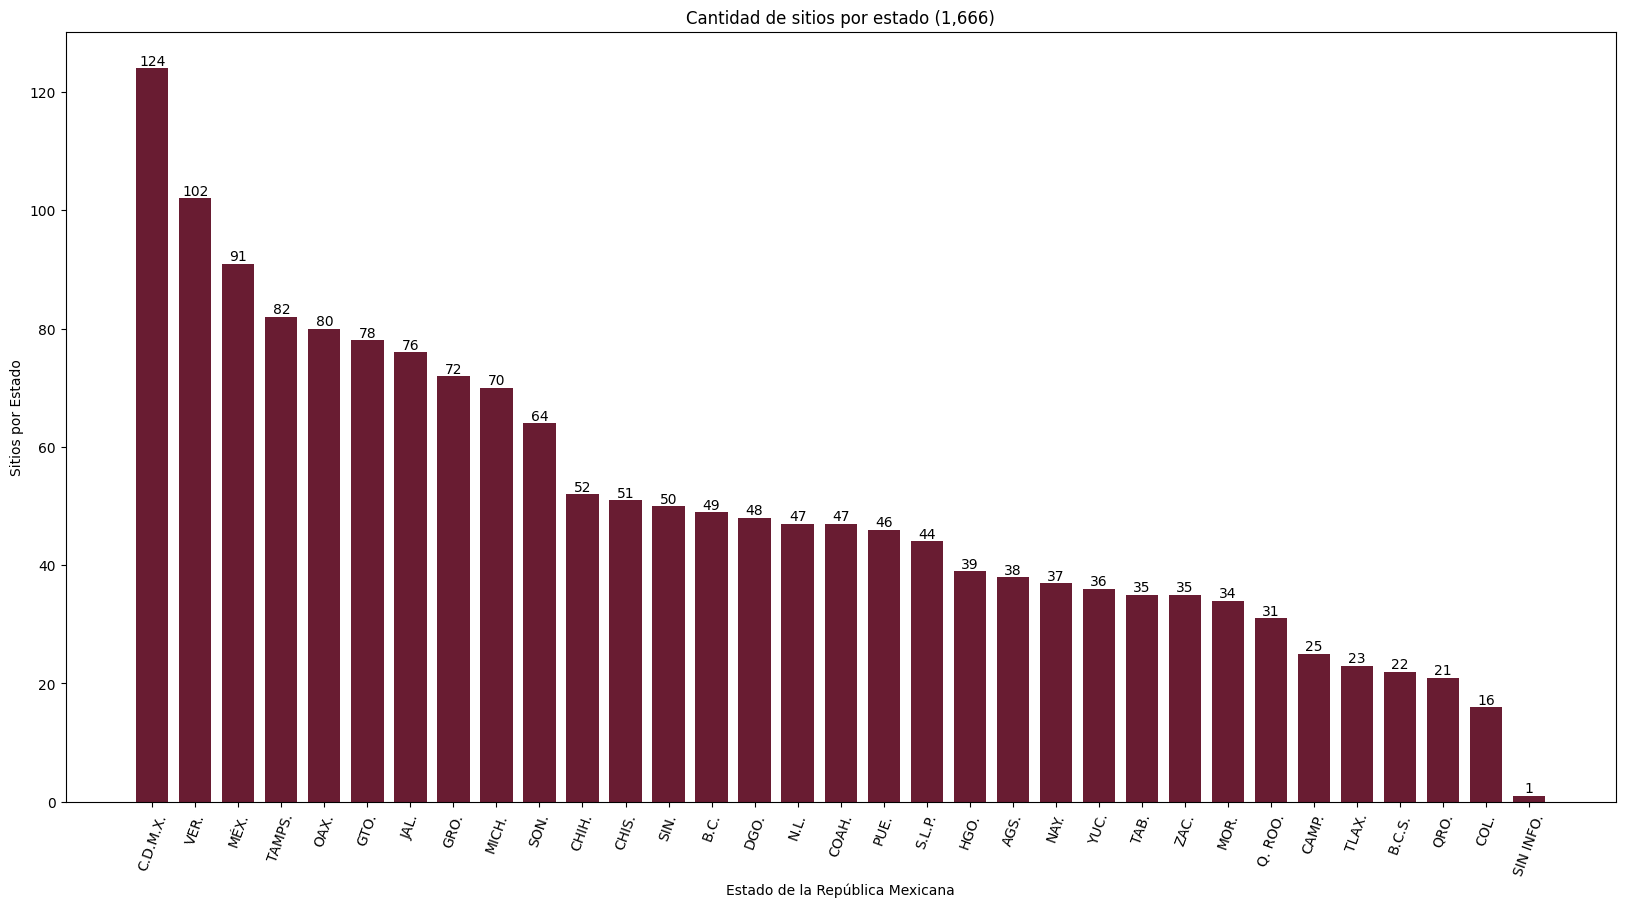

In [65]:
#                ╔═╗╔═╗╔╗╔╔╦╗╔═╗╔═╗  ╦═╗╔═╗╔═╗╦╔═╗╔╦╗╦═╗╔═╗╔═╗  ╔═╗╔═╗╦═╗  ╔═╗╔═╗╔╦╗╔═╗╔╦╗╔═╗
#                ║  ║ ║║║║ ║ ║╣ ║ ║  ╠╦╝║╣ ║ ╦║╚═╗ ║ ╠╦╝║ ║╚═╗  ╠═╝║ ║╠╦╝  ║╣ ╚═╗ ║ ╠═╣ ║║║ ║
#                ╚═╝╚═╝╝╚╝ ╩ ╚═╝╚═╝  ╩╚═╚═╝╚═╝╩╚═╝ ╩ ╩╚═╚═╝╚═╝  ╩  ╚═╝╩╚═  ╚═╝╚═╝ ╩ ╩ ╩═╩╝╚═╝
# Calvin S
# https://patorjk.com/software/taag/#p=display&f=Calvin%20S&t=CONTEO%20REGISTROS%20POR%20ESTADO

display(HTML('<h3 style="background-color: #ff7d00; color: white; text-align: center;" >Los sitios que en el campo de "Estado*" no hayan tenido información en automático se clasifican con el concepto de "SIN INFORMACIÓN"</h3>'))

# conteo de sitios por estado de la república
conteo_regs_por_edo = df.groupby(by='Estado*').agg(conteo_x_edo=('Estado*', 'count')).reset_index().sort_values(by='conteo_x_edo', ascending = False)

# creación de un a nueva columna para colocar el acrónimo de cada estado
conteo_regs_por_edo['acronym'] = conteo_regs_por_edo['Estado*'].apply(get_acronym)

# total de registros del archivo original
total_regs = '{:,}'.format(conteo_regs_por_edo['conteo_x_edo'].sum())

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(20, 10))

# Crear un gráfico de barras
ax.bar( conteo_regs_por_edo['acronym'], conteo_regs_por_edo['conteo_x_edo'], width=0.75, color='#691C32')

# Agregar etiquetas a las barras
for x in ax.containers:
    ax.bar_label(x, label_type='edge', fontsize=10)

# Establecer los títulos y etiquetas de los ejes
ax.set_title(f'Cantidad de sitios por estado ({total_regs})')
ax.set_xlabel('Estado de la República Mexicana', fontsize=10)
ax.set_ylabel('Sitios por Estado', fontsize=10)

# cambiar las etiquetas del eje 
# ax.set_xticklabels(labels=conteo_regs_por_edo['acronym'],fontsize=10)

# Girar las etiquetas del eje x
ax.tick_params(axis='x', labelrotation=70)

# Mostrar el gráfico
plt.show()

# exportar segmentación 
save_df_in_sheet_from_workbook(conteo_regs_por_edo, 'count_regs_by_edo', wb_original_results)

# eliminación de variables
del conteo_regs_por_edo, total_regs, fig, ax

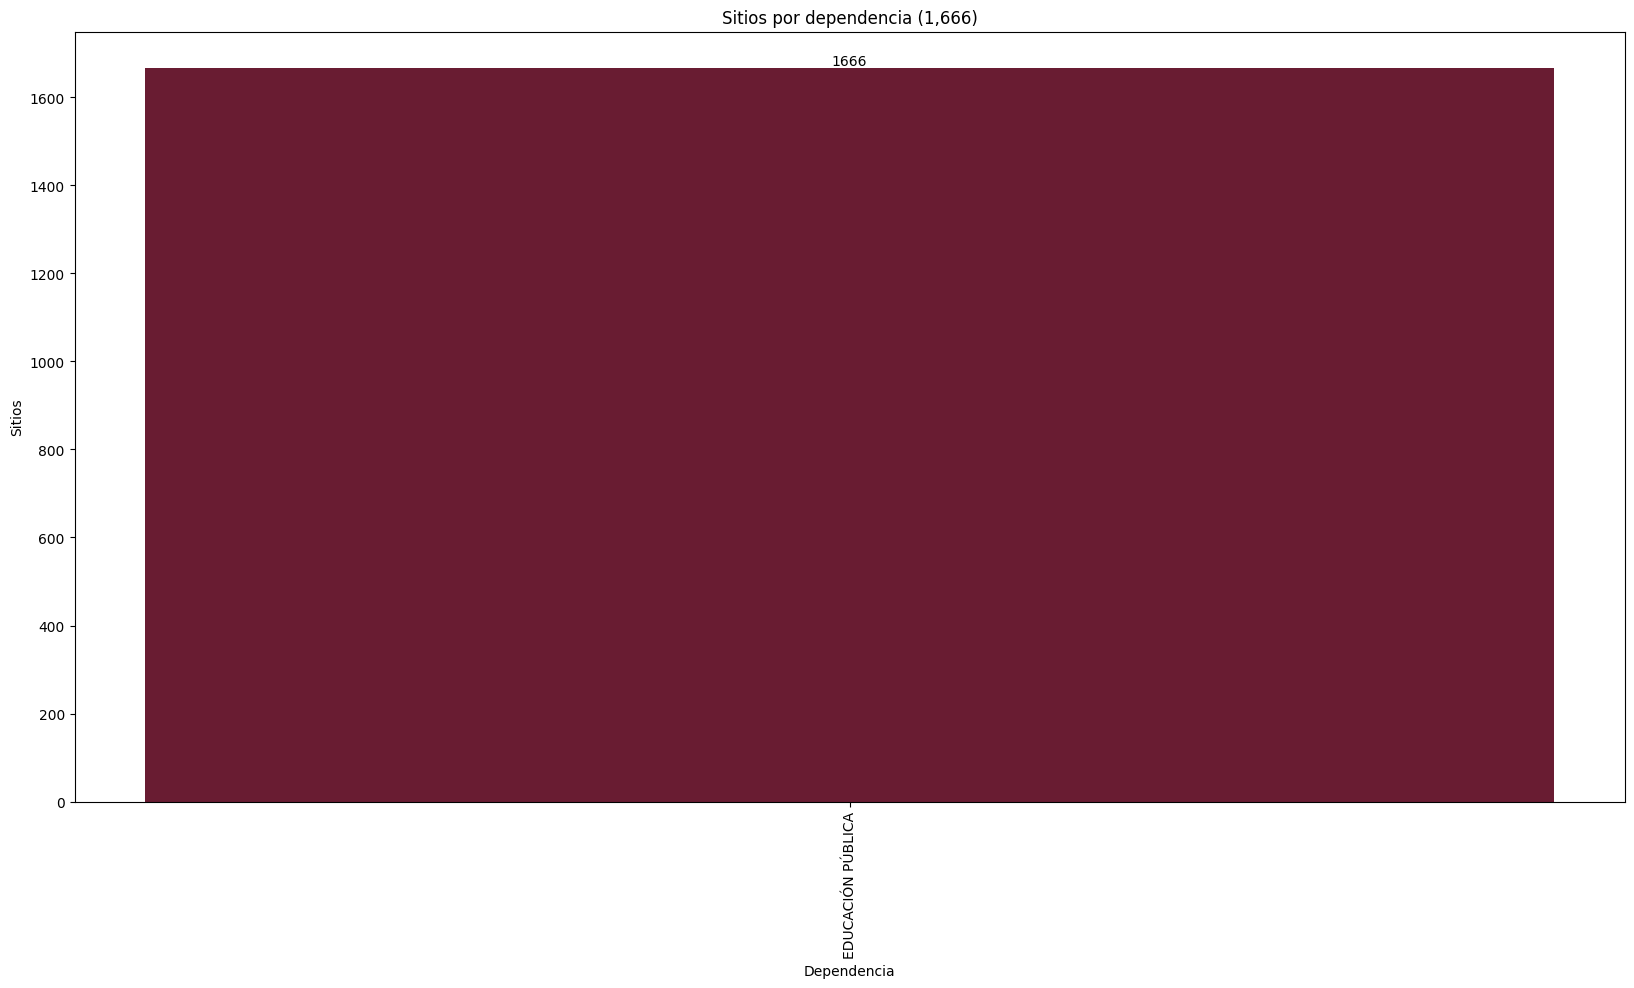

In [66]:
#           ╔═╗╔═╗╔╗╔╔╦╗╔═╗╔═╗  ╔═╗╦╔╦╗╦╔═╗╔═╗  ╔═╗╔═╗╦═╗  ╔╦╗╔═╗╔═╗╔═╗╔╗╔╔╦╗╔═╗╔╗╔╔═╗╦╔═╗
#           ║  ║ ║║║║ ║ ║╣ ║ ║  ╚═╗║ ║ ║║ ║╚═╗  ╠═╝║ ║╠╦╝   ║║║╣ ╠═╝║╣ ║║║ ║║║╣ ║║║║  ║╠═╣
#           ╚═╝╚═╝╝╚╝ ╩ ╚═╝╚═╝  ╚═╝╩ ╩ ╩╚═╝╚═╝  ╩  ╚═╝╩╚═  ═╩╝╚═╝╩  ╚═╝╝╚╝═╩╝╚═╝╝╚╝╚═╝╩╩ ╩

# agrupación de registros por dependencia 
conteo_regs_x_dep =  df.groupby(by='Dependencia*').agg(conteo_por_dependencia=('Dependencia*', 'count')).reset_index().sort_values(by='conteo_por_dependencia', ascending=False)

# total ted 
total_regs_por_dep = '{:,}'.format(conteo_regs_x_dep['conteo_por_dependencia'].sum())

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(20, 10))

# Crear un gráfico de barras
ax.bar( conteo_regs_x_dep['Dependencia*'], conteo_regs_x_dep['conteo_por_dependencia'], width=0.75, color='#691C32')

# Agregar etiquetas a las barras
for x in ax.containers:
    ax.bar_label(x, label_type='edge', fontsize=10)

# Establecer los títulos y etiquetas de los ejes
ax.set_title(f'Sitios por dependencia ({total_regs_por_dep})')
ax.set_xlabel('Dependencia', fontsize=10)
ax.set_ylabel('Sitios', fontsize=10)

# cambiar las etiquetas del eje 
# ax.set_xticklabels(labels=conteo_regs_x_dep['acronym'],fontsize=10)

# Girar las etiquetas del eje x
ax.tick_params(axis='x', labelrotation=90)

# Mostrar el gráfico
plt.show()

# exportar segmentación 
save_df_in_sheet_from_workbook(conteo_regs_x_dep, 'count_regs_by_dep', wb_original_results)

# eliminación de variables
del conteo_regs_x_dep, total_regs_por_dep, fig, ax

KeyError: 'conteo'

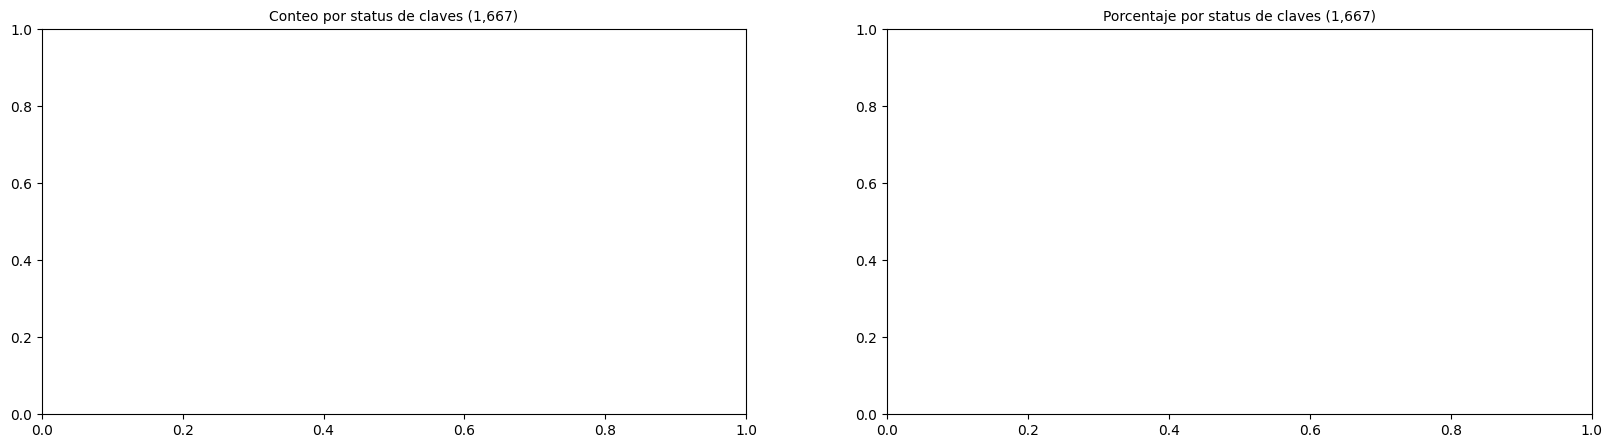

In [159]:
#				 ╔═╗╦╔╗╔  ╔═╗╦  ╔═╗╦  ╦╔═╗╔═╗  ╔═╗  ╔╦╗╦ ╦╔═╗╦  ╦╔═╗╔═╗╔╦╗╔═╗╔═╗  ╔═╗╔╗╔  ╔╦╗╦╔═╗╔╦╗╔═╗  ╔═╗╦═╗╔═╗╦ ╦╦╦  ╦╔═╗
#				 ╚═╗║║║║  ║  ║  ╠═╣╚╗╔╝║╣ ╚═╗  ║ ║   ║║║ ║╠═╝║  ║║  ╠═╣ ║║╠═╣╚═╗  ║╣ ║║║  ║║║║╚═╗║║║║ ║  ╠═╣╠╦╝║  ╠═╣║╚╗╔╝║ ║
#				 ╚═╝╩╝╚╝  ╚═╝╩═╝╩ ╩ ╚╝ ╚═╝╚═╝  ╚═╝  ═╩╝╚═╝╩  ╩═╝╩╚═╝╩ ╩═╩╝╩ ╩╚═╝  ╚═╝╝╚╝  ╩ ╩╩╚═╝╩ ╩╚═╝  ╩ ╩╩╚═╚═╝╩ ╩╩ ╚╝ ╚═╝

# df['Clave del inmueble*'].value_counts().rename_axis('Clave').reset_index(name='Conteo')
# df['Clave del inmueble*'].value_counts().reset_index().rename(columns={'index': 'Clave', 'Clave del inmueble*': 'Conteo'})
# df['Clave del inmueble*'].value_counts().rename('Conteo').reset_index(name='Clave')
# df['Clave del inmueble*'].value_counts().to_frame('Conteo').reset_index().rename(columns={'index': 'Clave'})
# conteo_claves = df['Clave del inmueble*'].value_counts().rename('Conteo').reset_index()

# conteo de claves
conteo_claves = df['Clave del inmueble*'].value_counts().rename_axis('Clave').reset_index(name='Conteo')

# eliminación de espacios
conteo_claves['Clave'] = conteo_claves['Clave'].str.strip()

sin_clv = conteo_claves[conteo_claves['Clave'] == '']['Conteo'].sum()
clv_unicas = conteo_claves[conteo_claves['Conteo'] == 1]['Conteo'].sum()
clv_duplicadas = conteo_claves[(conteo_claves['Conteo'] > 1) & (conteo_claves['Clave'] != '')]

# guardar los registros que tienen las claves repetidas 
save_df_in_sheet_from_workbook(dataframe= clv_duplicadas, sheetname='clvs_duplicadas', workbookname=wb_original_results)

# claves duplicadas se reasigna valor 
clv_duplicadas = clv_duplicadas['Conteo'].sum()

# data para crear un nuevo dataframe
data_conte_status_clvs = {
  'status': ['sin_clave', 'duplicadas', 'únicas'],
  'conteo': [sin_clv, clv_duplicadas, clv_unicas] }

total_regs = '{:,}'.format(sum([sin_clv, clv_duplicadas, clv_unicas]))

# dataframe conteo por status de claves
df_conteo_clv = pd.DataFrame(data_conte_status_clvs)

# convertir el valor "conteo" a numérico
df_conteo_clv['conteo'] = df_conteo_clv['conteo'].astype(int)

# ordenado del df status claves por conteo de forma descendente
df_conteo_clv = df_conteo_clv.sort_values(by='conteo', ascending=False)

# ****************************************************************************************
# #######################################################################################
# ****************************************************************************************

# Crear una figura y un eje
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Establecer el título del gráfico
ax[0].set_title(f'Conteo por status de claves ({total_regs})', fontsize=10)
ax[1].set_title(f'Porcentaje por status de claves ({total_regs})', fontsize=10)

# graficar el primer subplot como un gráfico de barras
df_conteo_clv.plot(kind='bar', ax=ax[0], color={"sin_clave": '#2d6a4f', "duplicadas": "#d00000", "únicas":"#1d3557"})

# graficar el segundo subplot como un gráfico de pastel
df_conteo_clv.plot(kind='pie', y='conteo', labels=df_conteo_clv['status'], ax=ax[1], autopct='%1.1f%%', textprops={'fontsize': 8})

# Eliminar las etiquetas del eje x en ambos subplots
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

# Añadir los valores a las columnas subplot 0
for x in ax[0].containers:
  ax[0].bar_label(x)

# mostrar la figura
plt.show()

# eliminación de variables
# del sin_clv, clv_duplicadas, clv_unicas, fig, ax, df_conteo_clv
df_conteo_clv


#checar código :

print(df_conteo_clv["columna"].unique()) # Imprime las etiquetas únicas de la columna
print({"sin_clave": '#2d6a4f', "duplicadas": "#d00000", "únicas":"#1d3557"}) # Imprime el diccionario de colores

#  --------------
df_conteo_clv.plot(kind='bar', ax=ax[0], color={"Sin clave": '#2d6a4f', "Duplicadas": "#d00000", "Únicas":"#1d3557"})

#  --------------
df_conteo_clv.plot(kind='bar', ax=ax[0], color={"sin_clave": '#2d6a4f', "duplicadas": "#d00000", "unicas":"#1d3557"})




In [ ]:
# CELDA ELIMINABLE
# Crear los dataframes
data_lat = {"si_lat": [si_lat], 'no_lat':[no_lat]}
data_lon = {'si_lon': [si_lon], 'no_lon': [no_lon]}
estatus_lat = pd.DataFrame(data_lat)
estatus_lon = pd.DataFrame(data_lon)

# Crear la figura y los subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Graficar cada dataframe en un subplot
estatus_lat.plot(kind='bar', ax=ax[0], color={"si_lat": '#2d6a4f', "no_lat": "#d00000"})
estatus_lon.plot(kind='bar', ax=ax[1], color={'si_lon': '#2d6a4f', 'no_lon':'#d00000'})

# Eliminar las etiquetas del eje x en ambos subplots
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

# Añadir los valores a las columnas subplot 0
for x in ax[0].containers:
  ax[0].bar_label(x)

# Añadir los valores a las columnas subplot 1
for r in ax[1].containers:
  ax[1].bar_label(r)

# Personalizar los subplots
ax[0].set_title(f'Latitud ({si_lat + no_lat})')
ax[1].set_title(f'Longitud ({si_lon + no_lon})')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [68]:
# obtener solo los registros con base en:
#		la clave no este con estatus de conectada segun la tabla de CFE
#		la clave no este en la base de datos preliminar del PCSP
archivo_segmentado  = df[(df['cfe_conexion_status'] == 'No conectada') & (df['en_preliminar_pcsp'] == 'NO')]
save_df_changes(archivo_segmentado, 'archivo_unicos_con_duplicados_regs_inters')

Se ha exportado el libro: archivo_unicos_con_duplicados_regs_inters.xlsx
Ruta del archivo: "Cambios_aplicados -> archivo_unicos_con_duplicados_regs_inters.xlsx"
